In [33]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [3]:
DATA_DIR = Path(".")


# Chargement csv

In [4]:
# PTB Diagnostic ECG (heartbeat database)
ptbdb_normal = pd.read_csv(DATA_DIR / "ptbdb_normal.csv", header=None)
ptbdb_abnormal = pd.read_csv(DATA_DIR / "ptbdb_abnormal.csv", header=None)

# MIT-BIH Arrhythmia Dataset
mitbih_train = pd.read_csv(DATA_DIR / "mitbih_train.csv", header=None)
mitbih_test = pd.read_csv(DATA_DIR / "mitbih_test.csv", header=None)


# Labels

In [ ]:
X_ptb_normal = ptbdb_normal.iloc[:, :-1]
y_ptb_normal = ptbdb_normal.iloc[:, -1]

X_ptb_abnormal = ptbdb_abnormal.iloc[:, :-1]
y_ptb_abnormal = ptbdb_abnormal.iloc[:, -1]

X_mitbih_train = mitbih_train.iloc[:, :-1]
y_mitbih_train = mitbih_train.iloc[:, -1]

X_mitbih_test = mitbih_test.iloc[:, :-1]
y_mitbih_test = mitbih_test.iloc[:, -1]


In [21]:
X_all = pd.concat(
    [X_ptb_normal, X_ptb_abnormal, X_mitbih_train, X_mitbih_test],
    axis=0,
    ignore_index=True
)

print("NaN par colonne :")
print(X_all.isnull().sum().max())


NaN par colonne :
0


# Lecture

In [13]:
datasets = {
    "ptbdb_normal": ptbdb_normal,
    "ptbdb_abnormal": ptbdb_abnormal,
    "mitbih_train": mitbih_train,
    "mitbih_test": mitbih_test,
}

for name, df in datasets.items():
    print(f"{name}: shape={df.shape}")


ptbdb_normal: shape=(4046, 188)
ptbdb_abnormal: shape=(10506, 188)
mitbih_train: shape=(87554, 188)
mitbih_test: shape=(21892, 188)


# Feature

In [23]:
def extract_features(row):
    x = row.values
    return [
        x.mean(),
        x.std(),
        x.min(),
        x.max(),
        np.percentile(x, 25),
        np.percentile(x, 50),
        np.percentile(x, 75),
        np.sum(x ** 2)  # énergie
    ]

features = X_all.apply(extract_features, axis=1, result_type="expand")
features.columns = [
    "mean", "std", "min", "max", "q25", "median", "q75", "energy"
]
print("Features extracted:")
print(features.head())


Features extracted:
       mean       std  min  max       q25    median       q75     energy
0  0.119207  0.158221  0.0  1.0  0.000000  0.115883  0.136548   7.338698
1  0.238641  0.202055  0.0  1.0  0.000000  0.252319  0.344774  18.284061
2  0.163529  0.147665  0.0  1.0  0.116354  0.134242  0.186542   9.078221
3  0.073524  0.135009  0.0  1.0  0.000000  0.043639  0.065459   4.419405
4  0.101952  0.149279  0.0  1.0  0.037108  0.080130  0.101567   6.110894


In [14]:
def plot_ecg(signal, title="", label=None):
    plt.figure(figsize=(10, 3))
    plt.plot(signal)
    plt.xlabel("Temps (échantillons)")
    plt.ylabel("Amplitude")
    if label is not None:
        plt.title(f"{title} | Label: {label}")
    else:
        plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()


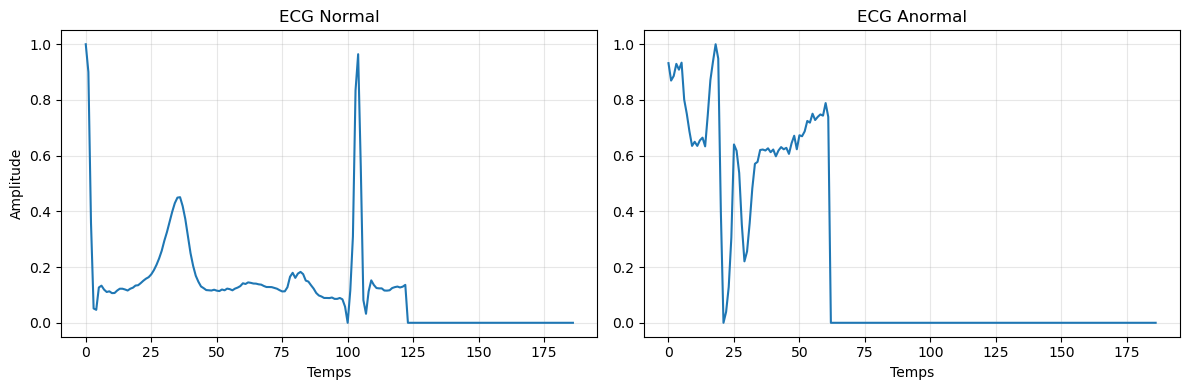

In [18]:
idx_n = 0
idx_a = 0

signal_n = ptbdb_normal.iloc[idx_n, :-1].values
signal_a = ptbdb_abnormal.iloc[idx_a, :-1].values

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(signal_n)
plt.title("ECG Normal")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(signal_a)
plt.title("ECG Anormal")
plt.xlabel("Temps")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


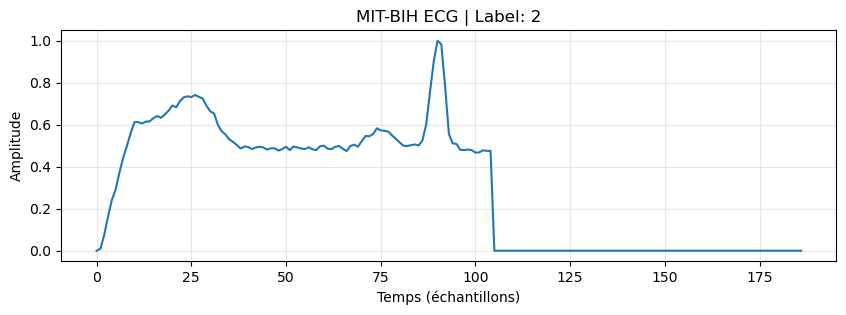

In [19]:
# choisir une classe précise (0 à 4)
classe = 2

idx = y_mitbih_train[y_mitbih_train == classe].index[0]
signal = mitbih_train.iloc[idx, :-1].values

plot_ecg(signal, title="MIT-BIH ECG", label=classe)


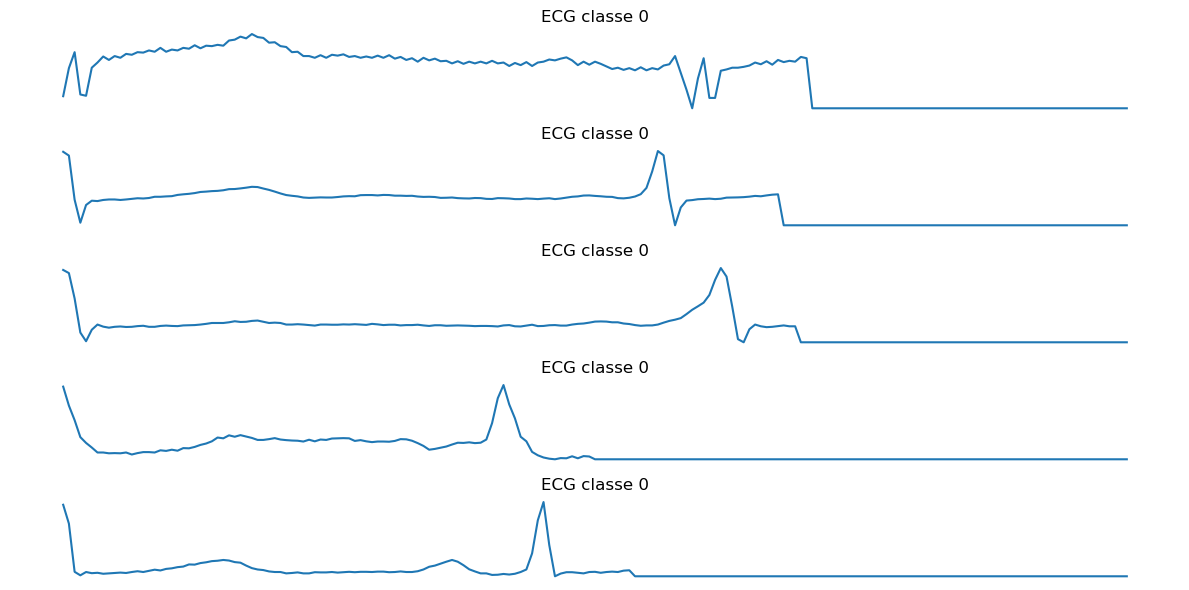

In [20]:
classe = 0
indices = y_mitbih_train[y_mitbih_train == classe].sample(5, random_state=42).index

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices, 1):
    plt.subplot(5, 1, i)
    plt.plot(mitbih_train.iloc[idx, :-1].values)
    plt.title(f"ECG classe {classe}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


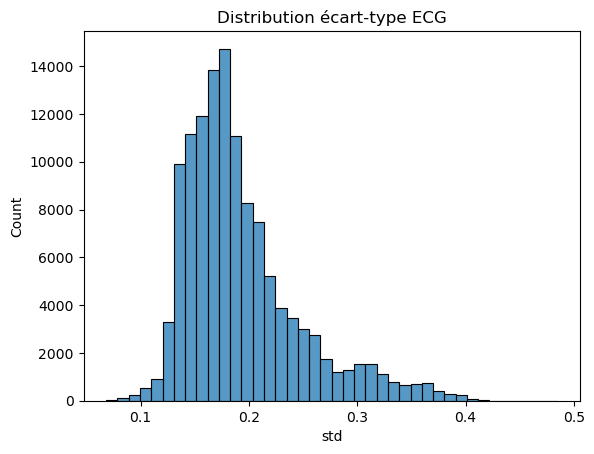

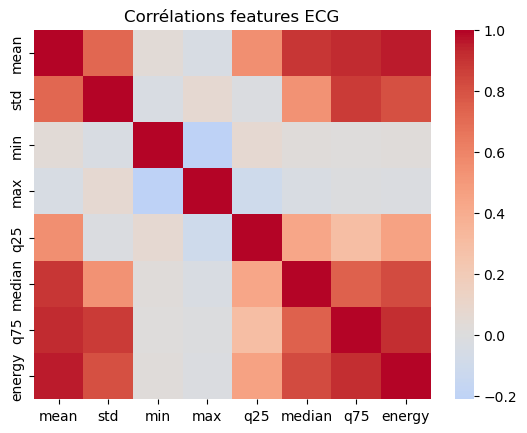

In [27]:


sns.histplot(features["std"], bins=40)
plt.title("Distribution écart-type ECG")
plt.show()

sns.heatmap(features.corr(), cmap="coolwarm", center=0)
plt.title("Corrélations features ECG")
plt.show()


In [29]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(features_scaled)


In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

In [31]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(features_scaled, clusters)
print("Silhouette score :", sil_score)


Silhouette score : 0.45166620705581506


In [38]:
X = X_all.replace([np.inf, -np.inf], np.nan).fillna(0).astype(np.float32)

# 3) Normalisation par battement (z-score ligne)
row_mean = X.mean(axis=1)
row_std = X.std(axis=1).replace(0, 1e-8)
Xn = (X.sub(row_mean, axis=0)).div(row_std, axis=0)

def extract_features_morpho(x: np.ndarray) -> list:
    dx = np.diff(x)
    p10, p25, p50, p75, p90 = np.percentile(x, [10, 25, 50, 75, 90])
    return [
        float(np.mean(np.abs(dx))),             # variation moyenne
        float(np.std(dx)),                      # dispersion pentes
        float(np.max(dx) - np.min(dx)),         # dynamique pentes
        float(p90 - p10),                       # amplitude robuste
        float(p75 - p25),                       # IQR
        float(np.mean(np.abs(x - p50))),        # déviation au médian
        float(np.mean(x**2)),                   # énergie (après normalisation)
    ]

features = np.vstack([extract_features_morpho(row) for row in Xn.to_numpy()])
features_scaled = StandardScaler().fit_transform(features)

n_features = features_scaled.shape[1]  # ici 7
candidate_dims = [2, 3, 4, 5, 6, 7]
candidate_dims = [d for d in candidate_dims if d <= n_features]

best = {"sil": -1, "pca_dim": None, "labels": None}

for pca_dim in candidate_dims:
    X_pca = PCA(n_components=pca_dim, random_state=42).fit_transform(features_scaled)

    kmeans = KMeans(
        n_clusters=5,
        random_state=42,
        n_init=50,
        max_iter=500
    )
    labels = kmeans.fit_predict(X_pca)

    sil = silhouette_score(X_pca, labels)
    if sil > best["sil"]:
        best = {"sil": sil, "pca_dim": pca_dim, "labels": labels}

print(f"Best silhouette (K=5) = {best['sil']:.4f} avec PCA n_components = {best['pca_dim']}")

# 6) Variables utiles pour la suite (viz / crosstab)
labels_kmeans = best["labels"]
pca_best_dim = best["pca_dim"]


Best silhouette (K=5) = 0.4002 avec PCA n_components = 2
